# GOES Data

In [185]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from spacepy import pycdf
from scipy.ndimage import uniform_filter1d

Functions to load noise

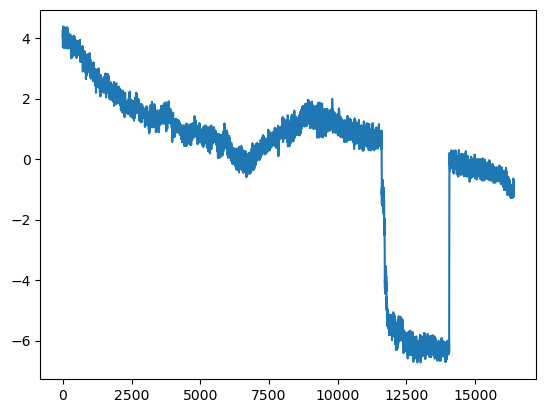

In [198]:
import netCDF4 as nc
dataset  = nc.Dataset(r'utility\SPACE_DATA\goes16.nc')
variable_data = dataset.variables['b_ib_sensor'][700000:]
B_ib = np.array(variable_data)
variable_data = dataset.variables['b_ob_sensor'][700000:]
B_ob = np.array(variable_data)
B = np.array([ B_ob.T, B_ib.T])
B = B[:,:,::10]
B = B - uniform_filter1d(B, size=10000, axis=-1,mode='wrap')
noise = B[1] - B[0]
plt.plot(noise[0])

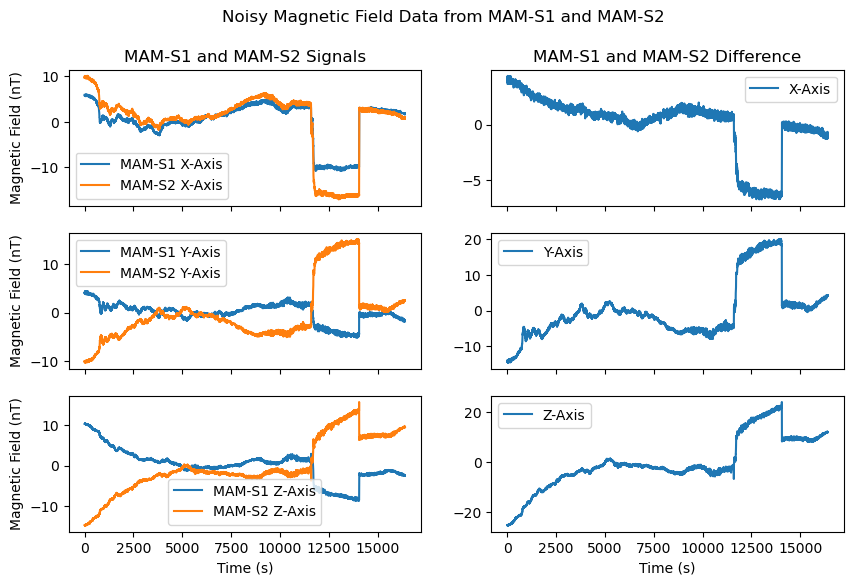

In [199]:
"Create a 3 x 2-panel plot of MAM-S1 and MAM-S2 data with overlapping magnetometers in the same panel"
fig, axs = plt.subplots(3, 2, figsize=(10, 6), sharex=True)
fig.suptitle("Noisy Magnetic Field Data from MAM-S1 and MAM-S2")
axs[0,0].set_title("MAM-S1 and MAM-S2 Signals")
axs[0,0].plot(B[0,0], label="MAM-S1 X-Axis")
axs[0,0].plot(B[1,0], label="MAM-S2 X-Axis")
axs[0,0].set_ylabel("Magnetic Field (nT)")
#axs[0,0].set_ylim(-250, 150)
axs[0,0].legend()

axs[1,0].plot(B[0,1], label="MAM-S1 Y-Axis")
axs[1,0].plot(B[1,1], label="MAM-S2 Y-Axis")
axs[1,0].set_ylabel("Magnetic Field (nT)")
#axs[1,0].set_ylim(-250, 150)
axs[1,0].legend()

axs[2,0].plot(B[0,2], label="MAM-S1 Z-Axis")
axs[2,0].plot(B[1,2], label="MAM-S2 Z-Axis")
axs[2,0].set_xlabel("Time (s)")
axs[2,0].set_ylabel("Magnetic Field (nT)")
#axs[2,0].set_ylim(-250, 150)
axs[2,0].legend()

axs[0,1].set_title("MAM-S1 and MAM-S2 Difference")
axs[0,1].plot(B[1,0]-B[0,0], label="X-Axis")
axs[0,1].legend()
#axs[0,1].set_ylim(-100, 100)

axs[1,1].plot(B[1,1]-B[0,1], label="Y-Axis")
axs[1,1].legend()
#axs[1,1].set_ylim(-100, 100)

axs[2,1].plot(B[1,2]-B[0,2], label="Z-Axis")
#axs[2,1].set_ylim(-100, 100)
axs[2,1].set_xlabel("Time (s)")
axs[2,1].legend()

plt.show()



Find Coupling Coefficients

In [200]:
from algorithms import RAMEN
from scipy.stats import pearsonr
import importlib
importlib.reload(RAMEN)

axis = 0
RAMEN.fs = 1
#RAMEN.weights = np.geomspace(10,.1,B.shape[0])
RAMEN.sspTol = 15
result_ramen = RAMEN.clean(np.flip(np.copy(B[:,axis]), axis = 0), triaxial=False)

print(pearsonr(result_ramen, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])

0.7266249288151292
0.9391960114060017


In [201]:
from algorithms import WAICUPV2
importlib.reload(WAICUPV2)
WAICUPV2.fs = 1
WAICUPV2.uf=500
WAICUPV2.detrend = True
#WAICUPV2.weights = np.geomspace(1,.1,B.shape[0])
WAICUPV2.gain_method = 'sheinker'
WAICUPV2.sspTol = 15
result_waicup = WAICUPV2.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_waicup, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])

0.013685637952497155
0.9391960114060017


In [202]:
from algorithms import HOG
importlib.reload(HOG)

HOG.fs = 1
HOG.weights = np.geomspace(10,.1,B.shape[0])
HOG.sspTol = 14
HOG.gain_method = 'ramen'

result_hog= HOG.clean(np.copy(B[:,axis]), triaxial=False)
print(pearsonr(result_hog, noise[axis])[0])
print(pearsonr(B[1,axis], noise[axis])[0])

0.8369876774993603
0.9391960114060017


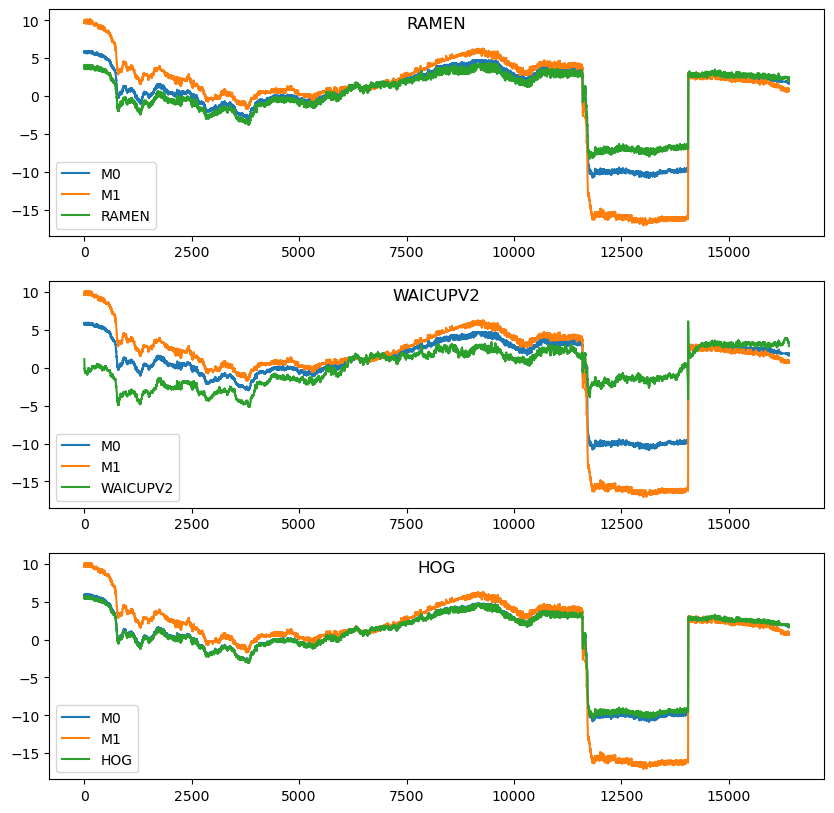

In [203]:
# Make 3,1 subplot and overlay swarm on each result. Set location of each title to within the plot
fig, axs = plt.subplots(3, 1, figsize=(10, 10))
axs[0].plot(B[0,axis], label = 'M0')
axs[0].plot(B[1,axis], label = 'M1')
axs[0].plot(result_ramen, label = 'RAMEN')
axs[0].set_title("RAMEN", y=1.0, pad=-14)
axs[0].legend()

axs[1].plot(B[0,axis], label = 'M0')
axs[1].plot(B[1,axis], label = 'M1')
axs[1].plot(result_waicup, label = 'WAICUPV2')
axs[1].set_title('WAICUPV2', y=1.0, pad=-14)
axs[1].legend()

axs[2].plot(B[0,axis], label = 'M0')
axs[2].plot(B[1,axis], label = 'M1')
axs[2].plot(result_hog, label = 'HOG')
axs[2].set_title('HOG', y=1.0, pad=-14)
axs[2].legend()


In [204]:
"Take Continuous Wavelet Transform"
import fcwt
fs= 10  # Hz
f0 = 0.001  # Hz
f1 = fs / 2  # Hz

# take transform of B_kplo Z-axis
freqs_michibiki, out_michibiki= fcwt.cwt(B[1,axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)
freqs_michibiki = np.flip(freqs_michibiki)

# take transform of WAICUP Z-axis
_, out_ramen = fcwt.cwt(resu, fs, f0, f1, fn=300, scaling='linear', nthreads=12)

# take transform of B_kplo Z-axis
_, out_noise = fcwt.cwt(noise[axis], fs, f0, f1, fn=300, scaling='linear', nthreads=12)

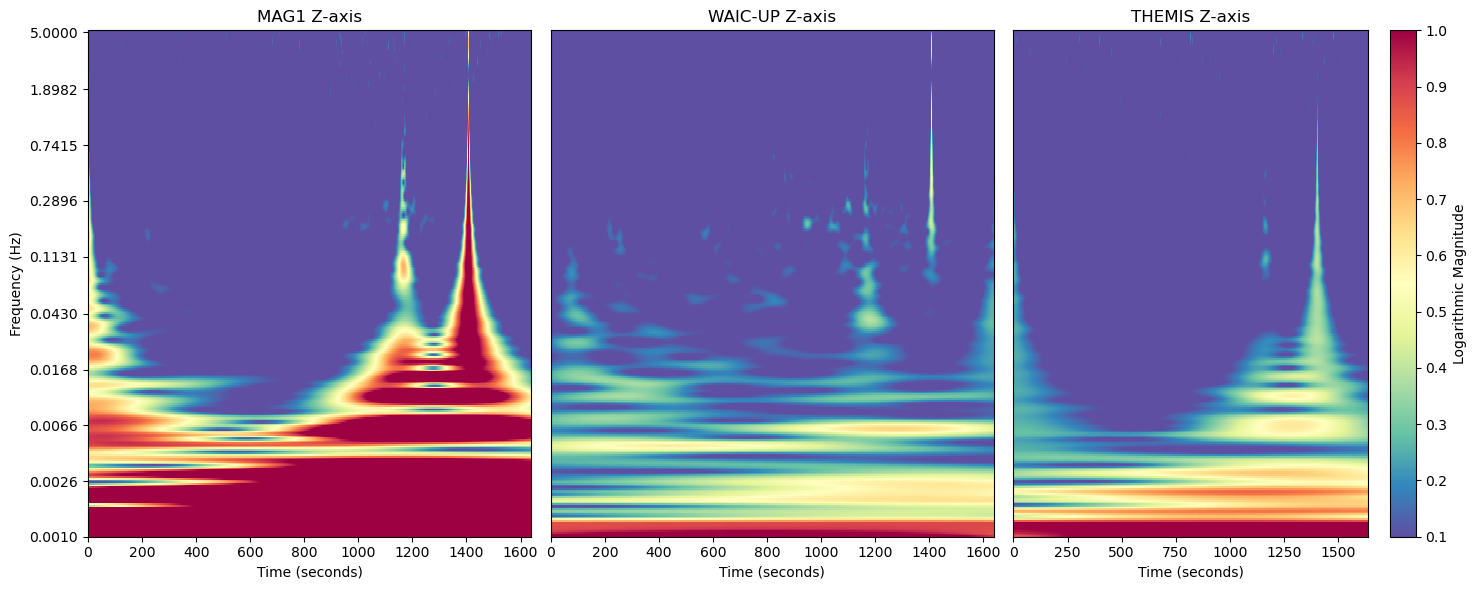

In [205]:

fig, axs = plt.subplots(1, 3, figsize=(15, 6))
extent = [0, out_michibiki.shape[1] / fs, 0, out_michibiki.shape[0]]
cax1 = axs[0].imshow(np.abs(out_michibiki), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=1)
cax2 = axs[1].imshow(np.abs(out_ramen), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=1)
cax3 = axs[2].imshow(np.abs(out_noise), aspect='auto', extent=extent, origin='upper', interpolation='none', cmap='Spectral_r', vmin=0.1, vmax=1)

#fig.colorbar(cax1, ax=axs[0], label='Logarithmic Magnitude')
#fig.colorbar(cax2, ax=axs[1], label='Logarithmic Magnitude')
fig.colorbar(cax3, ax=axs[2], label='Logarithmic Magnitude')

yticks_kplo = np.linspace(0, len(freqs_michibiki) - 1, 10).astype(int)
yticklabels_kplo = [f"{freqs_michibiki[i]:.4f}" for i in yticks_kplo]

axs[0].set_yticks(yticks_kplo)
axs[0].set_yticklabels(yticklabels_kplo)
axs[0].set_xlabel('Time (seconds)')
axs[0].set_ylabel('Frequency (Hz)')
axs[0].set_title("MAG1 Z-axis")

# TURN OFF YTICKS FOR AXS[1] AND AXS[2]
axs[1].set_yticks([])
axs[1].set_xlabel('Time (seconds)')
axs[1].set_title("WAIC-UP Z-axis")
axs[2].set_yticks([])
axs[2].set_xlabel('Time (seconds)')
axs[2].set_title("THEMIS Z-axis")


plt.tight_layout()
plt.show()
